In [16]:
%load_ext zipline
%matplotlib inline
%configs InlineBackend.figure_format = 'png'

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


UsageError: Line magic function `%configs` not found.


Entire data start date: 2013-01-02
Entire data end date: 2016-12-30
Backtest months: 48


,Backtest
Annual return,12.9%
Cumulative returns,62.5%
Annual volatility,12.8%
Sharpe ratio,1.01
Calmar ratio,1.00
Stability,0.83
Max drawdown,-12.9%
Omega ratio,1.19
Sortino ratio,1.46
Skew,-0.23


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.87,2015-07-16,2015-08-25,2015-10-28,75
1,8.97,2016-04-01,2016-06-27,2016-11-29,173
2,8.18,2015-10-28,2016-01-20,2016-03-11,98
3,7.51,2013-12-31,2014-02-03,2014-06-10,116
4,7.24,2014-09-18,2014-10-16,2014-10-31,32


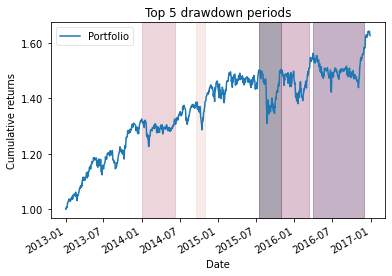

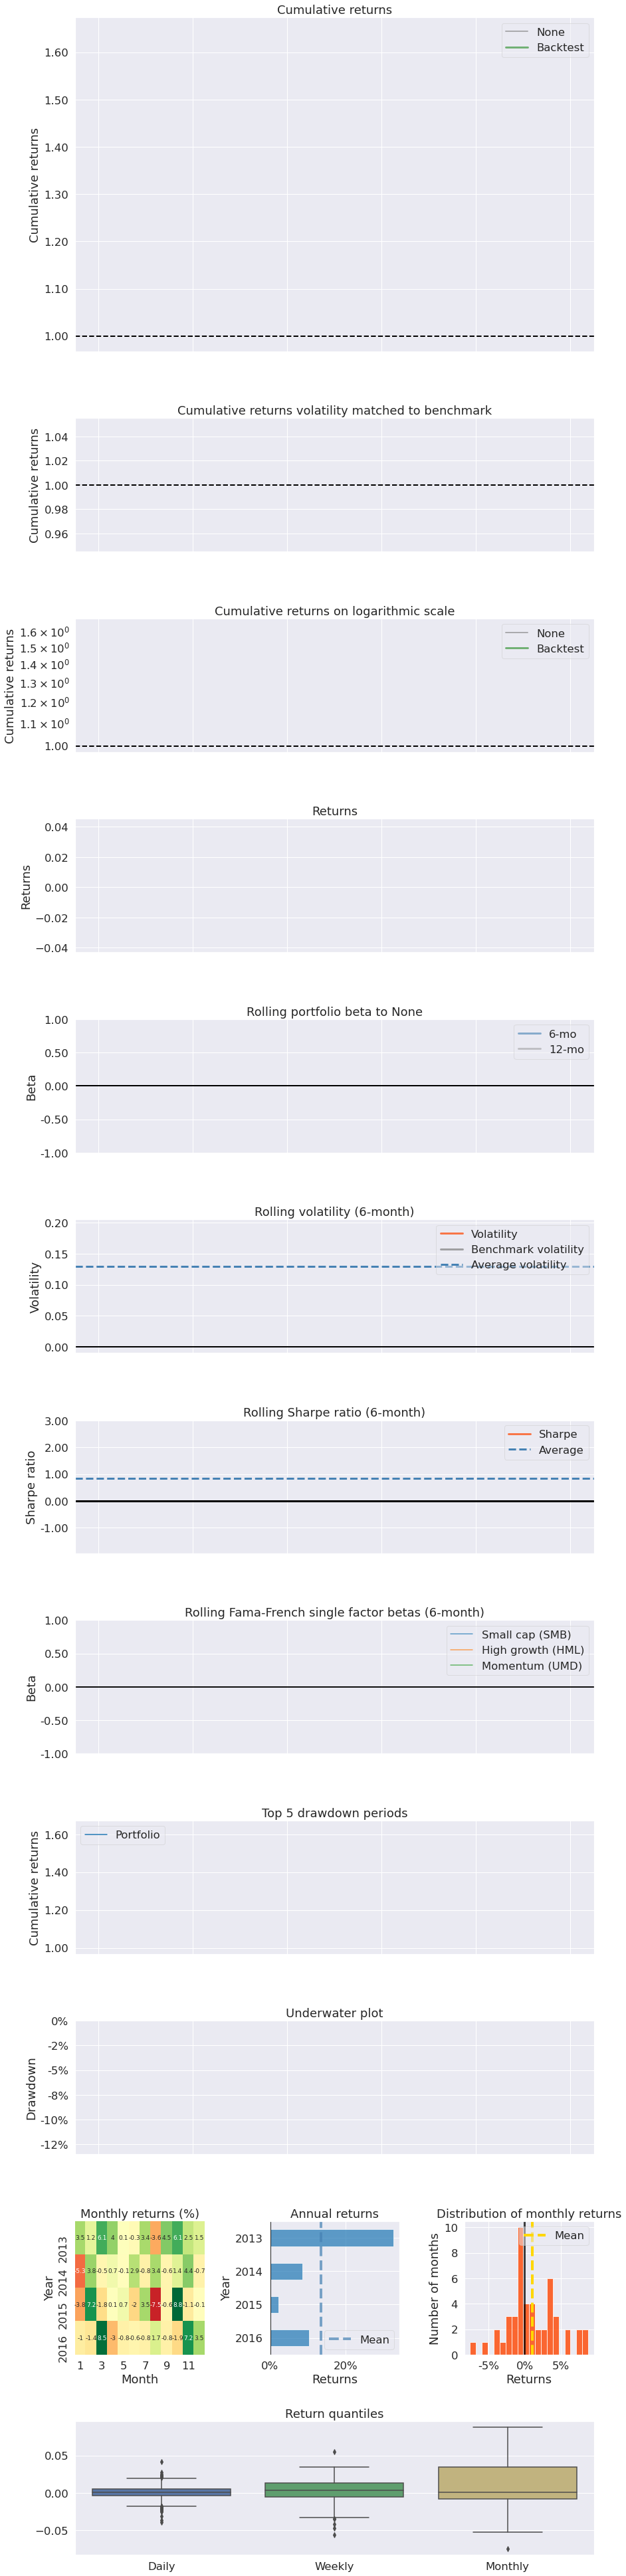

Stress Events,mean,min,max
Apr14,0.00%,-1.76%,0.84%
Oct14,0.07%,-1.70%,1.58%
Fall2015,-0.19%,-3.91%,4.13%
New Normal,0.05%,-3.91%,4.13%


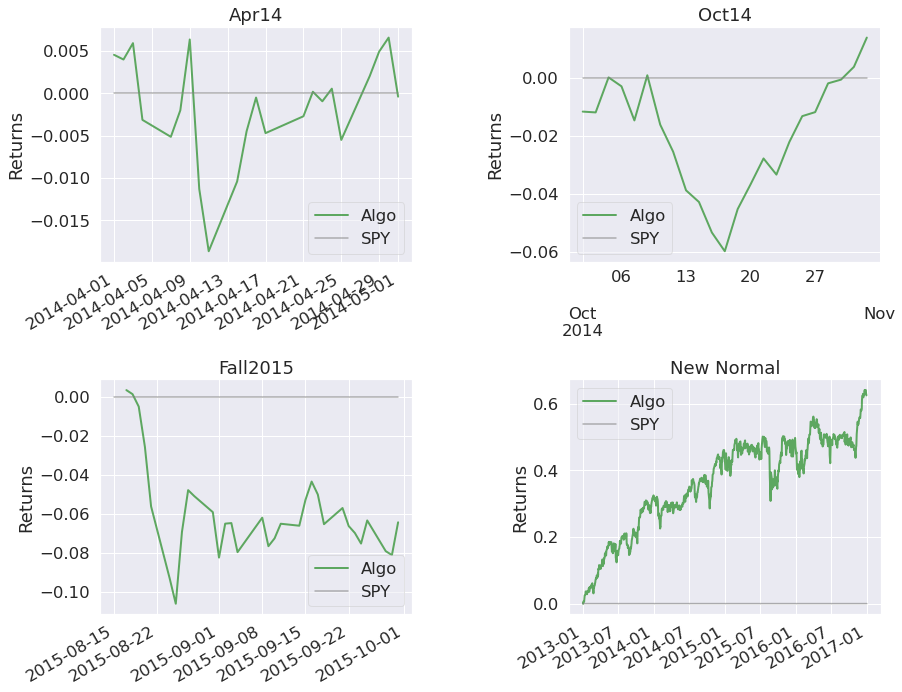

Top 10 long positions of all time,max
NKE,11.85%
WBA,11.54%
GS,11.45%
BA,11.40%
MCD,11.35%
INTC,11.25%
WMT,11.10%
UNH,11.07%
HD,11.06%
UTX,10.97%


Top 10 short positions of all time,max


Top 10 positions of all time,max
NKE,11.85%
WBA,11.54%
GS,11.45%
BA,11.40%
MCD,11.35%
INTC,11.25%
WMT,11.10%
UNH,11.07%
HD,11.06%
UTX,10.97%


All positions ever held,max
NKE,11.85%
WBA,11.54%
GS,11.45%
BA,11.40%
MCD,11.35%
INTC,11.25%
WMT,11.10%
UNH,11.07%
HD,11.06%
UTX,10.97%


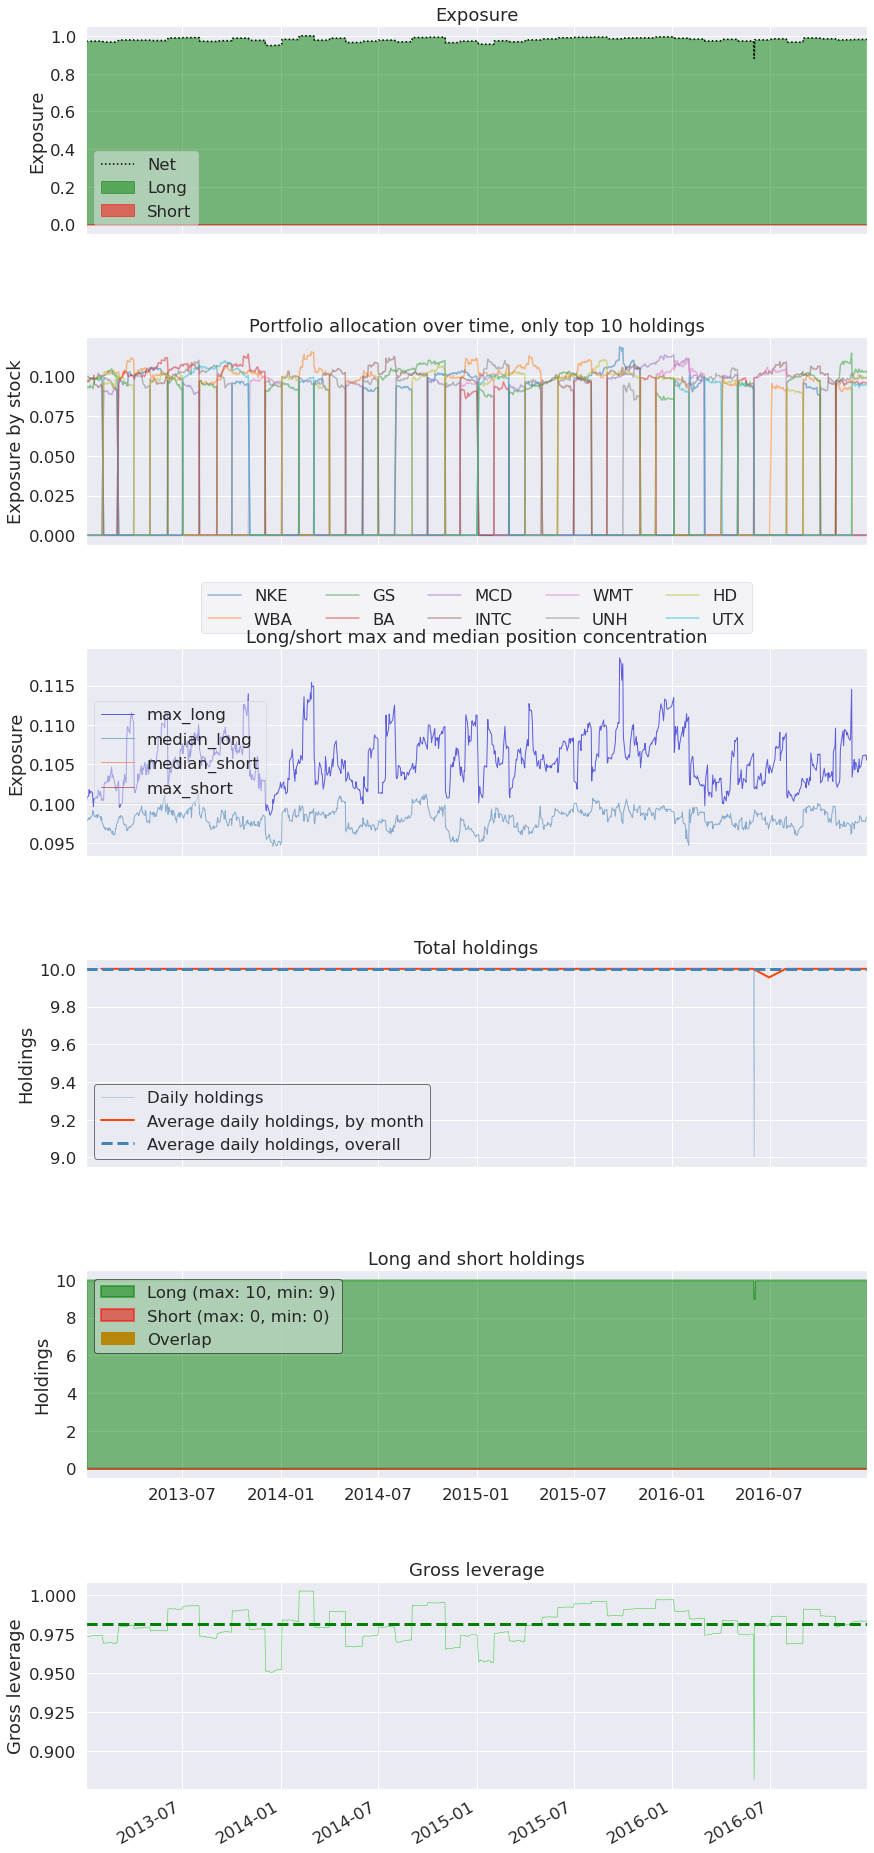

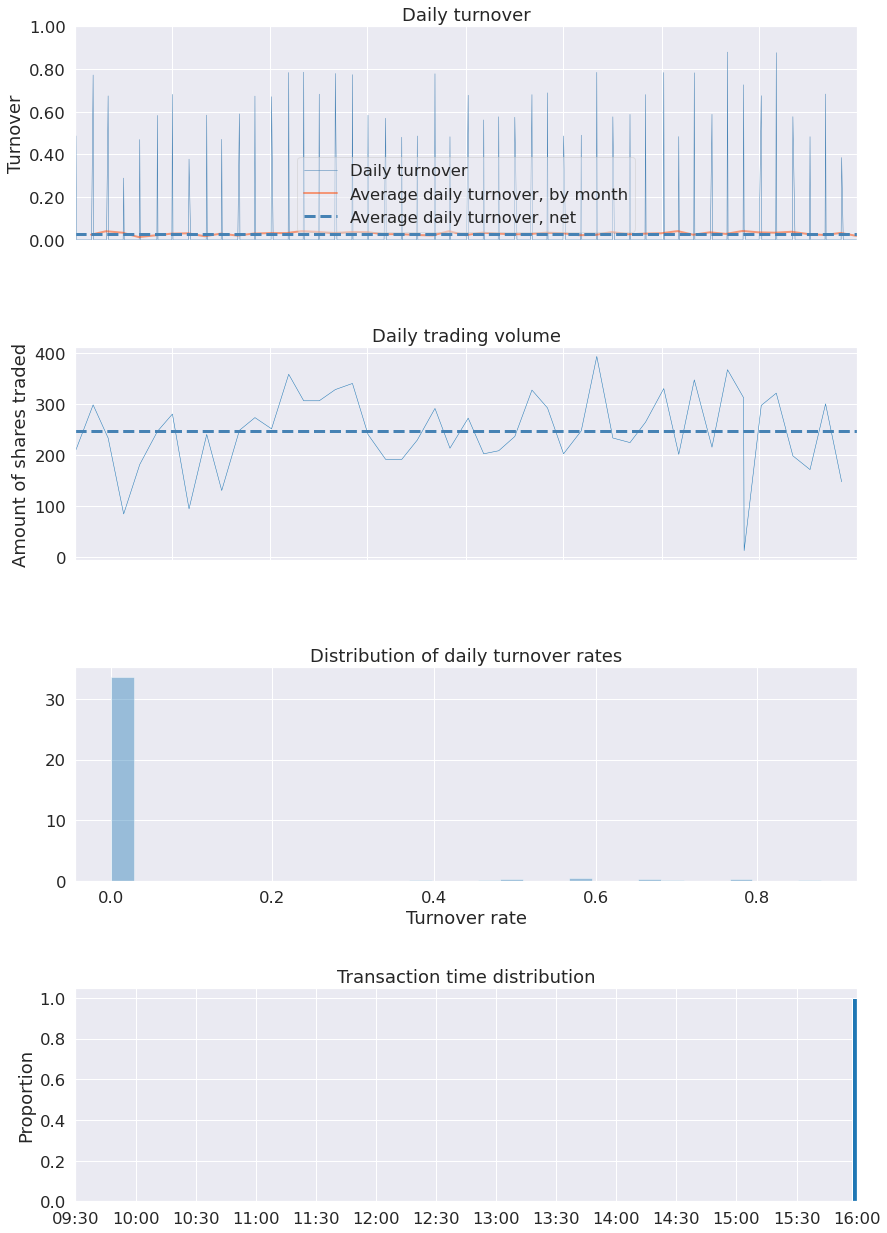

In [17]:
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol,  \
    schedule_function, date_rules, time_rules
from datetime import datetime
import pytz
import pyfolio as pf
import pandas as pd

def initialize(context):
    # Which stocks to trade
    dji = [
        "AAPL",
        "AXP",
        "BA",
        "CAT",
        "CSCO",
        "CVX",
        "DIS",
        "GS",
        "HD",
        "IBM",
        "INTC",
        "JNJ",
        "JPM",
        "KO",
        "MCD",
        "MMM",
        "MRK",
        "MSFT",
        "NKE",
        "PFE",
        "PG",
        "TRV",
        "UNH",
        "UTX",
        "V",
        "VZ",
        "WBA",
        "WMT",
        "XOM",  
    ]
    
    # Make symbol list from tickers
    context.universe = [symbol(s) for s in dji]
    
    # History window
    context.history_window = 20
    
    # Size of our portfolio
    context.stocks_to_hold = 10
    
    # Schedule the daily trading routine for once per month
    schedule_function(handle_data, date_rules.month_start(), time_rules.market_close())    
    
def month_perf(ts):
    perf = (ts[-1] / ts[0]) - 1
    return perf
    
def handle_data(context, data):
    # Get history for all the stocks.
    hist = data.history(context.universe, "close", context.history_window, "1d")
    
    # This creates a table of percent returns, in order.
    perf_table = hist.apply(month_perf).sort_values(ascending=False)

    # Make buy list of the top N stocks
    buy_list = perf_table[:context.stocks_to_hold]
    
    # The rest will not be held.
    the_rest = perf_table[context.stocks_to_hold:]
    
    # Place target buy orders for top N stocks.
    for stock, perf in buy_list.iteritems():
        stock_weight = 1 / context.stocks_to_hold

        # Place order
        if data.can_trade(stock):
            order_target_percent(stock, stock_weight)

    # Make sure we are flat the rest.
    for stock, perf in the_rest.iteritems():
        # Place order
        if data.can_trade(stock):
            order_target_percent(stock, 0.0)     
            
def analyze(context, perf):
    # Use PyFolio to generate a performance report
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
    # pf.create_returns_tear_sheet(returns, benchmark_rets=None)
    start_ref = datetime(2013, 1, 1, 0, 0, 0, 0, pytz.utc)
    end_ref = datetime(2017, 1, 1, 0, 0, 0, 0, pytz.utc)
    benchmark_rets=pd.Series(0,index=pd.date_range(start_ref,end_ref), dtype="float64")
    pf.create_full_tear_sheet(returns, benchmark_rets=benchmark_rets, positions=positions, transactions=transactions)
        

# Set start and end date
start = pd.Timestamp('2013-01-01', tz='utc')
end = pd.Timestamp('2017-01-01', tz='utc')

# Fire off the backtest
results = run_algorithm(
    start=start, 
    end=end, 
    initialize=initialize, 
    analyze=analyze, 
    capital_base=10000, 
    data_frequency = 'daily', 
    bundle='quantopian-quandl' 
)
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

# Make fake benchmark returns


pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')

# just create a series with 0 returns
start_ref = datetime(2013, 1, 1, 0, 0, 0, 0, pytz.utc)
end_ref = datetime(2017, 1, 1, 0, 0, 0, 0, pytz.utc)
benchmark_rets=pd.Series(0,index=pd.date_range(start_ref,end_ref), dtype="float64")
pf.create_full_tear_sheet(returns, benchmark_rets=benchmark_rets, positions=positions, transactions=transactions)
# pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')